# **Introduction to Deep Learning: Final Project - Sign Language MNIST**

**Submitted by:**

Roei Matz       205871478

Yotam Silverman 313532418

## Project Description

### Introduction
 
Our project's objective is to design and build a neural network that will identify the letters given in each sign language image.
The project is based on the artice written by M. Bilgin and K. Mutludoğan [1]. We will implement and compare three networks, two of them are based on this artice.

### Dataset

The data for this project was gathered from the [sign language MNIST](https://www.kaggle.com/datamunge/sign-language-mnist) dataset from the website kaggle.com.

The dataset format is patterned to match closely with the classic MNIST. Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions). The training data (27,455 cases) and test data (7172 cases) are approximately half the size of the standard MNIST but otherwise similar with a header row of label, pixel1,pixel2….pixel784 which represent a single 28x28 pixel image with grayscale values between 0-255.

The original hand gesture image data was generated by multiple users repeating the gesture against different backgrounds.
The Sign Language MNIST data came from extending the original hand gesture image data that was relatively small (1704).
The data augmentation was based on ImageMagick and included cropping to hands-only, gray-scaling, resizing, and then creating at least 50+ variations to enlarge the quantity.
The modification and expansion strategy was filters ('Mitchell', 'Robidoux', 'Catrom', 'Spline', 'Hermite'), along with 5% random pixelation, +/- 15% brightness/contrast, and 3 degrees rotation.
The training set and the test set are comoposed of different original images.

### Limitations

Our main challenge in the project is the small data set we used. As we mentioned, the original number of images was only 1704 so the owner of the data set used data augmentation in order to extend the number of samples.
Therefore, when we split the training set to training and validation, some of the samples will be similar to each other. This could prevent us from knowing if our model is overfitted. 
In order to avoid overfitting, we added a dropout layer to our model.

### Benchmark

Our project is a classification problem so our benchmark was calculated by counting the right predictions and dividing by all of the predictions.
The predictions were calculated by picking the index with the highest value corresponding to the label.
We implemented this metric in the *get_accuracy()* function you will see below.
Our objective is to receive ~90% accuracy on the test set.

## Setup

In [ ]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

# CapsNet related imports
import os
import pandas as pd
from sklearn.metrics import accuracy_score
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
import gc

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

## Data

Mount Google Drive and load the project's data:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
train_csv = open('/content/gdrive/My Drive/Intro_to_Deep_Learning/sign_mnist_train.csv')
test_csv  = open('/content/gdrive/My Drive/Intro_to_Deep_Learning/sign_mnist_test.csv')
x_train_val = np.genfromtxt(train_csv, delimiter=',')[1:,1:]
x_test = np.genfromtxt(test_csv, delimiter=',')[1:,1:]

train_csv = open('/content/gdrive/My Drive/Intro_to_Deep_Learning/sign_mnist_train.csv')
test_csv  = open('/content/gdrive/My Drive/Intro_to_Deep_Learning/sign_mnist_test.csv')
t_train_val = np.genfromtxt(train_csv, delimiter=',')[1:,0]
t_test =  np.genfromtxt(test_csv, delimiter=',')[1:,0]

Mounted at /content/gdrive


Splitting the data set to train, validation and test: 

(**Note:** As mentioned before, the sign language MNIST data is composed of a relatively small amount of data that has been augmented by some manipulations, meaning some images in the validation set were originated from images in the training set and vice versa. So, the validation set would be similar to the training set and we might get really good results with the validation set)

In [ ]:
x_train = x_train_val[0:round(0.7*len(x_train_val))]
x_val = x_train_val[round(0.7*len(x_train_val)):]

t_train = t_train_val[0:round(0.7*len(t_train_val))]
t_val = t_train_val[round(0.7*len(t_train_val)):]

Making a dictionary for the alphabet:

In [ ]:
import string
alphabet_dict = dict(zip(range(0,26),string.ascii_uppercase))

print(alphabet_dict)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


Here, we show few examples of the letters notions in the sign language:

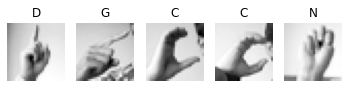

In [ ]:
plt.figure(figsize=(6, 3))
for i in range(0,5): 
  plt.subplot(1, 5, i + 1)
  img = x_train[i]
  img = np.reshape(img, (28, 28))
  plt.imshow(img, cmap='Greys_r')
  plt.title(alphabet_dict[int(t_train[i])])
  plt.axis('off');

Normalizing the data set:

In [ ]:
def img_norm(data):
  output = []
  for img in data: 
    img = (img - np.mean(img))/np.std(img)  #zero mean and a unit standard deviation
    output.append(np.array(img))
  return np.array(output)

# def img_norm(data): 
#   output = []
#   for img in data: 
#     img = img/255                      #pixels' values between 0 to 1
#     output.append(np.array(img))
#   return np.array(output)

# def img_norm(data): 
#   output = []
#   for img in data: 
#     img = img/255 - 0.5                #pixels' values between -0.5 to 0.5
#     output.append(np.array(img))
#   return np.array(output)

x_train_norm = img_norm(x_train)
x_val_norm = img_norm(x_val)
x_test_norm = img_norm(x_test)

In [ ]:
train_loader = torch.utils.data.DataLoader(
    np.concatenate((t_train[:,None], x_train_norm),axis=1),
    batch_size=64, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    np.concatenate((t_val[:,None], x_val_norm),axis=1),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    np.concatenate((t_test[:,None], x_test_norm),axis=1),
    batch_size=64, shuffle=True)

After checking the network with several normalztions techniques:
* Dividing each image by 255 so we will have values between 0 and 1.
* After dividing by 255, subtracting 0.5 so that the elements of will be between -0.5 and 0.5.
* Normalizing by subtracting the mean of each image and dividing the standard deviation. 

We chose the third normalization method becuase it provided the best accuracy with our models.

In order to examine the model performance, we used a confusion matrix. 
The confusion matrix will show us the numbers of correct predictions vs number of wrong predictions for each letter.

In [ ]:
def show_confusion_matrix(conf_mat):
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=[alphabet_dict[i] for i in list(range(0,9))+list(range(10,25))])
    fig, ax = plt.subplots(figsize=(14, 12))
    ax.set_xlabel('Preicted Label', fontsize=16)
    ax.set_ylabel('True Label', fontsize=16) 
    disp.plot(ax=ax)

## Our model

Defining CNN model: we will try 1-3 convolutional layers, Relu activations and Maxpooling for our CNN model. We used one dropout layer, Relu activation function and two fully connected layers. The activation function for the output layer is log softmax.

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size, num_of_layers):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.num_of_layers = num_of_layers
        self.ks = 5
        self.length_calc = int(np.floor((np.sqrt(input_size)-self.ks+1)//(2**num_of_layers)))  
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=self.ks)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=self.ks, padding='same')
        self.conv3 = nn.Conv2d(n_feature, n_feature, kernel_size=self.ks, padding='same')
        self.dropout = nn.Dropout(0.3)    
        self.fc1 = nn.Linear(n_feature*self.length_calc*self.length_calc, 50)
        self.fc2 = nn.Linear(50, output_size)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)                   
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout(x)
        if self.num_of_layers > 1:
          x = self.conv2(x)
          x = F.relu(x)
          x = F.max_pool2d(x, kernel_size=2)
          if self.num_of_layers > 2:
            x = self.conv3(x)
            x = F.relu(x)
            x = F.max_pool2d(x, kernel_size=2)
            
        x = x.view(-1, self.n_feature*self.length_calc*self.length_calc)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

For the training function, we used the Adam optimizer and the negative log lilkelihood loss function.

In order to evaluate the performance of the network, we defined the *get_accuracy()* function.

In [ ]:
def get_accuracy(model, loader=train_loader):
    model.eval()
    loss = 0
    correct = 0
    pred_list = []
    true_list = []
    for ar in loader:
        data = ar[:,1:]
        label = ar[:,0]
        # send to device
        data, label = data.to(device), label.to(device)
        
        data = data.view(-1, 28*28)
        data = data.view(-1, 1, 28, 28)
        pred = model(data)
        loss += F.nll_loss(pred, label.long(), reduction='sum').item() # sum up batch loss                                                               
        pred = pred.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(label.data.view_as(pred)).cpu().sum().item()
 
        for y in pred.squeeze(1):
          pred_list.append(y.cpu())

        for y in label:  
          true_list.append(y.cpu())
          
    conf_mat = confusion_matrix(true_list, pred_list, labels=list(range(0,9))+list(range(10,25)))    
    loss /= len(loader.dataset)
    accuracy = 100. * correct / len(loader.dataset)
    
    return loss, accuracy, conf_mat

def train(model, lr=0.01, max_iters=300,num_epochs=6,show_prints=True):
    model.train()
    train_accs, valid_accs = [], []
    epochs = []
    optimizer = optim.Adam(model.parameters(), lr=lr)
    n = 0 # the number of iterations
    iters, losses = [], []
    iters_sub = []

    for epoch in range(0, num_epochs):

        for batch_idx, ar in enumerate(train_loader):           
            data = ar[:,1:]
            label = ar[:,0]
            # send to device
            data, label = data.to(device), label.to(device)
            data = data.view(-1, 28*28)
            data = data.view(-1, 1, 28, 28)

            optimizer.zero_grad()
            pred = model(data)
            loss = F.nll_loss(pred, label.long())
            loss.backward()
            optimizer.step()

            iters.append(n)
            losses.append(loss)

            if batch_idx % 50 == 0: 
                
                iters_sub.append(n)
                train_loss, train_acc, _ = get_accuracy(model, loader=train_loader)
                train_accs.append(train_acc)

                valid_loss, valid_acc, _ = get_accuracy(model, loader=val_loader)
                valid_accs.append(valid_acc)
                if show_prints:
                  print("Iter %d. [Val Acc %f%%] [Train Acc %f%%, Loss %f]" % (n, valid_acc, train_acc, train_loss))

            # increment the iteration number
            n += 1
            if n > max_iters:
                return iters, losses, iters_sub, train_accs, valid_accs
    return iters, losses, iters_sub, train_accs, valid_accs

In [ ]:
# Training settings 
n_features = 10       # number of feature maps

input_size  = 28*28   # images are 28x28 pixels
output_size = 26      # there are 26 classes

First, we tried several CNNs using different number of layers.

Here, we defined 3 CNN models with one layer, two layers and three layers:

In [ ]:
model_cnn1 = CNN(input_size, n_features, output_size,1)
model_cnn1.to(device)
model_cnn2 = CNN(input_size, n_features, output_size,num_of_layers=2)
model_cnn2.to(device)
model_cnn3 = CNN(input_size, n_features, output_size,3)
model_cnn3.to(device)

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv3): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=90, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=26, bias=True)
)

In [ ]:
lr = 0.001

iters, losses, iters_sub, train_accs, valid_accs = train(model_cnn1.double(), lr=lr, max_iters=300,num_epochs=6,show_prints=True)
iters, losses, iters_sub, train_accs, valid_accs = train(model_cnn2.double(), lr=lr, max_iters=300,num_epochs=6,show_prints=True)
iters, losses, iters_sub, train_accs, valid_accs = train(model_cnn3.double(), lr=lr, max_iters=300,num_epochs=6,show_prints=True)

Iter 0. [Val Acc 7.927644%] [Train Acc 8.694973%, Loss 3.217840]
Iter 50. [Val Acc 62.389219%] [Train Acc 63.112707%, Loss 1.351683]
Iter 100. [Val Acc 77.528226%] [Train Acc 77.895723%, Loss 0.740515]
Iter 150. [Val Acc 84.338958%] [Train Acc 84.831928%, Loss 0.495922]
Iter 200. [Val Acc 92.363725%] [Train Acc 92.803622%, Loss 0.299576]
Iter 250. [Val Acc 96.418599%] [Train Acc 96.716620%, Loss 0.183448]
Iter 300. [Val Acc 97.948282%] [Train Acc 98.147570%, Loss 0.133740]
Iter 0. [Val Acc 4.370523%] [Train Acc 4.402123%, Loss 3.264628]
Iter 50. [Val Acc 45.441301%] [Train Acc 44.442710%, Loss 1.841709]
Iter 100. [Val Acc 67.815952%] [Train Acc 68.212093%, Loss 1.043097]
Iter 150. [Val Acc 76.289911%] [Train Acc 76.938287%, Loss 0.738752]
Iter 200. [Val Acc 80.915382%] [Train Acc 80.679571%, Loss 0.572262]
Iter 250. [Val Acc 89.607867%] [Train Acc 90.144656%, Loss 0.340876]
Iter 300. [Val Acc 93.699162%] [Train Acc 94.302217%, Loss 0.234589]
Iter 0. [Val Acc 4.103436%] [Train Acc 3.980

We can see that we recieved the best results with the one layer network:

In [ ]:
val_loss, val_acc_1, val_conf_mat = get_accuracy(model_cnn1,loader=val_loader)
print("Validation set for 1 layer: Average loss: %f, Accuracy: %f%%" % (val_loss,val_acc_1)) 
val_loss, val_acc_2, val_conf_mat = get_accuracy(model_cnn2,loader=val_loader)
print("Validation set for 2 layers: Average loss: %f, Accuracy: %f%%" % (val_loss,val_acc_2)) 
val_loss, val_acc_3, val_conf_mat = get_accuracy(model_cnn3,loader=val_loader)
print("Validation set for 3 layers: Average loss: %f, Accuracy: %f%%" % (val_loss,val_acc_3)) 

Validation set for 1 layer: Average loss: 0.138249, Accuracy: 97.948282%
Validation set for 2 layers: Average loss: 0.239070, Accuracy: 93.699162%
Validation set for 3 layers: Average loss: 0.498777, Accuracy: 84.496783%


As we learned, if we increase the number of hidden layers then the neural network complexity increases and it might not lead to more accurate models. In fact, too many layers usually lead to overfitting.

Here, we checked the model performance changing the learning rate.

(Notice that we have in some cases 100% accuracy because of the data augmentation.)

In [ ]:
lrs = [x / 10000 for x in range(1, 110, 20)]
lr_accs_1 = []

for lr in lrs:
    # reseting the model
    model_cnn1 = CNN(input_size, n_features, output_size,num_of_layers=1)
    model_cnn1.to(device)
    print(f"---learning rate: {lr}---")
    train(model_cnn1.double(), lr=lr, max_iters=300,num_epochs=6,show_prints=False)
    val_loss, val_acc_1, val_conf_mat = get_accuracy(model_cnn1,loader=val_loader)
    print("Validation set for 1 layer: Average loss: %f, Accuracy: %f%%" % (val_loss,val_acc_1)) 
    lr_accs_1.append(val_acc_1)

---learning rate: 0.0001---
Validation set for 1 layer: Average loss: 1.481804, Accuracy: 67.706689%
---learning rate: 0.0021---
Validation set for 1 layer: Average loss: 0.023186, Accuracy: 99.927158%
---learning rate: 0.0041---
Validation set for 1 layer: Average loss: 0.013803, Accuracy: 99.890737%
---learning rate: 0.0061---
Validation set for 1 layer: Average loss: 0.003526, Accuracy: 100.000000%
---learning rate: 0.0081---
Validation set for 1 layer: Average loss: 0.009595, Accuracy: 99.854316%
---learning rate: 0.0101---
Validation set for 1 layer: Average loss: 0.206264, Accuracy: 94.002671%


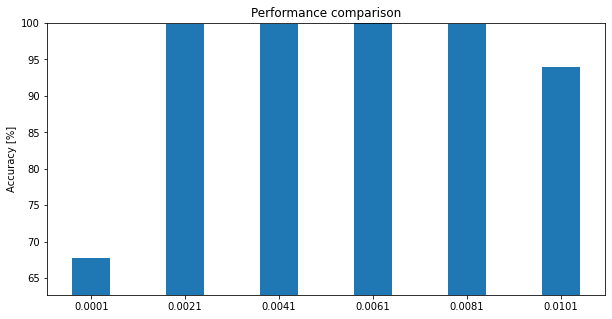

In [ ]:
fig = plt.figure(figsize = (10, 5))
lrs_values = [str(i) for i in lrs]

# creating a bar plot
plt.bar(lrs_values, lr_accs_1, width=0.4)
plt.ylim((min(lr_accs_1)-5, 100))
plt.ylabel('Accuracy [%]')
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(10)
plt.title('Performance comparison');

As expected, we received bad accuracy for the lower learning rate because when the learning rate is relatively too small, the convergence will be slow and the loss function may get to a local minima.

In addition, for the highest learning rate we got a lower accuracy than the other cases. This is because the change of the parameters was major, so we possibly "skipped" the global minima.

And for last, we checked the model performance changing the batch size.

(Again, we got extremely high accuracy becuase of the data augmentation.)

In [ ]:
bs_list = range(16, 240, 16)
bs_accs = []
lr = 0.004

for bs in bs_list:
    train_loader = torch.utils.data.DataLoader(
        np.concatenate((t_train[:,None], x_train_norm),axis=1),
        batch_size=bs, shuffle=True)

    val_loader = torch.utils.data.DataLoader(
        np.concatenate((t_val[:,None], x_val_norm),axis=1),
        batch_size=bs, shuffle=True)
    
    # reseting the model
    model_cnn1 = CNN(input_size, n_features, output_size,num_of_layers=1)
    model_cnn1.to(device)
    print(f"---batch size: {bs}---")
    train(model_cnn1.double(), lr=lr, max_iters=640,num_epochs=6,show_prints=False)
    val_loss, val_acc_1, val_conf_mat = get_accuracy(model_cnn1,loader=val_loader)
    print("Validation set for 1 layer: Average loss: %f, Accuracy: %f%%" % (val_loss,val_acc_1)) 
    bs_accs.append(val_acc_1)

---batch size: 16---
Validation set for 1 layer: Average loss: 0.048164, Accuracy: 98.628141%
---batch size: 32---
Validation set for 1 layer: Average loss: 0.037618, Accuracy: 99.138036%
---batch size: 48---
Validation set for 1 layer: Average loss: 0.001140, Accuracy: 100.000000%
---batch size: 64---
Validation set for 1 layer: Average loss: 0.001009, Accuracy: 100.000000%
---batch size: 80---
Validation set for 1 layer: Average loss: 0.001231, Accuracy: 100.000000%
---batch size: 96---
Validation set for 1 layer: Average loss: 0.000608, Accuracy: 100.000000%
---batch size: 112---
Validation set for 1 layer: Average loss: 0.000886, Accuracy: 100.000000%
---batch size: 128---
Validation set for 1 layer: Average loss: 0.000811, Accuracy: 100.000000%
---batch size: 144---
Validation set for 1 layer: Average loss: 0.000519, Accuracy: 100.000000%
---batch size: 160---
Validation set for 1 layer: Average loss: 0.000844, Accuracy: 100.000000%
---batch size: 176---
Validation set for 1 layer

Text(0.5, 0, 'Batch sizes')

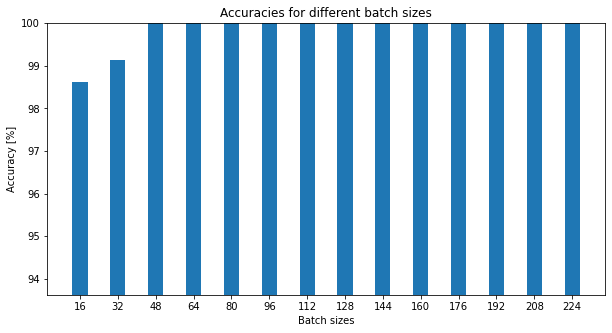

In [ ]:
fig = plt.figure(figsize = (10, 5))
bs_values = [str(i) for i in bs_list]

# creating a bar plot
plt.bar(bs_values, bs_accs, width=0.4)
plt.ylim((min(bs_accs)-5, 100))
plt.ylabel('Accuracy [%]')
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(10)
plt.title("Accuracies for different batch sizes");
plt.xlabel("Batch sizes")

In conclusion, we chose the following hyperparameters:

number of layers = 1, 
learning rate = 0.004, 
batch size = 144

The convolutional neural network is comprised of one convolutional layer with kernel size 5 . The number of input channels is  1, because it is a grayscale image, and number of output channels, n_feature, is 10. The convolutaional layer is followed by a ReLU activation and a MaxPooling layer with kernel size 2.

Note that after passing through the convolutional layer, the  H1×W1=28×28  image is converted into n_feature images of size  H2(=H1−Fc+1)×W2(=W1−Fc+1)=24×24 , which after MaxPooling is reduced to size  12×12.

Then, the fully-connetected layer recieves the input of size *n_feature*x12x12.

In [ ]:
bs = 144
lr = 0.004

train_loader = torch.utils.data.DataLoader(
    np.concatenate((t_train[:,None], x_train_norm),axis=1),
    batch_size=bs, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    np.concatenate((t_val[:,None], x_val_norm),axis=1),
    batch_size=bs, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    np.concatenate((t_test[:,None], x_test_norm),axis=1),
    batch_size=bs, shuffle=True)

# reseting the model
model_cnn1 = CNN(input_size, n_features, output_size,num_of_layers=1)
model_cnn1.to(device)
# training
iters, losses, iters_sub, train_accs, valid_accs = train(model_cnn1.double(), lr=lr, max_iters=1000,num_epochs=6,show_prints=True)

Iter 0. [Val Acc 10.598519%] [Train Acc 10.198772%, Loss 3.160396]
Iter 50. [Val Acc 86.548501%] [Train Acc 87.366011%, Loss 0.409373]
Iter 100. [Val Acc 98.227510%] [Train Acc 98.324487%, Loss 0.076772]
Iter 134. [Val Acc 99.830035%] [Train Acc 99.869914%, Loss 0.025228]
Iter 184. [Val Acc 99.987860%] [Train Acc 100.000000%, Loss 0.007235]
Iter 234. [Val Acc 99.987860%] [Train Acc 100.000000%, Loss 0.003792]
Iter 268. [Val Acc 100.000000%] [Train Acc 100.000000%, Loss 0.002887]
Iter 318. [Val Acc 100.000000%] [Train Acc 100.000000%, Loss 0.002193]
Iter 368. [Val Acc 100.000000%] [Train Acc 100.000000%, Loss 0.001585]
Iter 402. [Val Acc 100.000000%] [Train Acc 100.000000%, Loss 0.001374]
Iter 452. [Val Acc 100.000000%] [Train Acc 100.000000%, Loss 0.001076]
Iter 502. [Val Acc 100.000000%] [Train Acc 100.000000%, Loss 0.000897]
Iter 536. [Val Acc 100.000000%] [Train Acc 100.000000%, Loss 0.000818]
Iter 586. [Val Acc 100.000000%] [Train Acc 100.000000%, Loss 0.000669]
Iter 636. [Val Acc 

We plot the learning curves: the training loss curve and the training and validation accuracies curves.

In [ ]:
def plot_learning_curve(iters, losses, iters_sub, train_accs, val_accs):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(iters_sub, train_accs, label="Train")
    if (val_accs != []):
      plt.plot(iters_sub, val_accs, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

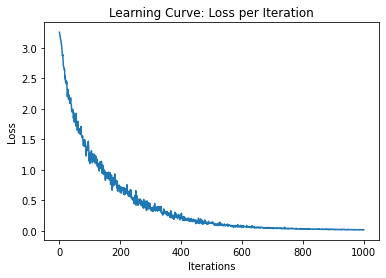

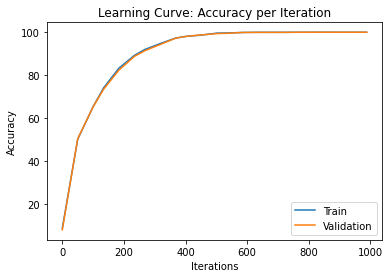

In [ ]:
plot_learning_curve(iters, losses, iters_sub, train_accs, valid_accs)

We check our model performance by calculating the loss and the accuracy of the model with the test set and also, by displaying the results with a confusion matrix.

Test set: Average loss: 0.674308, Accuracy: 88%


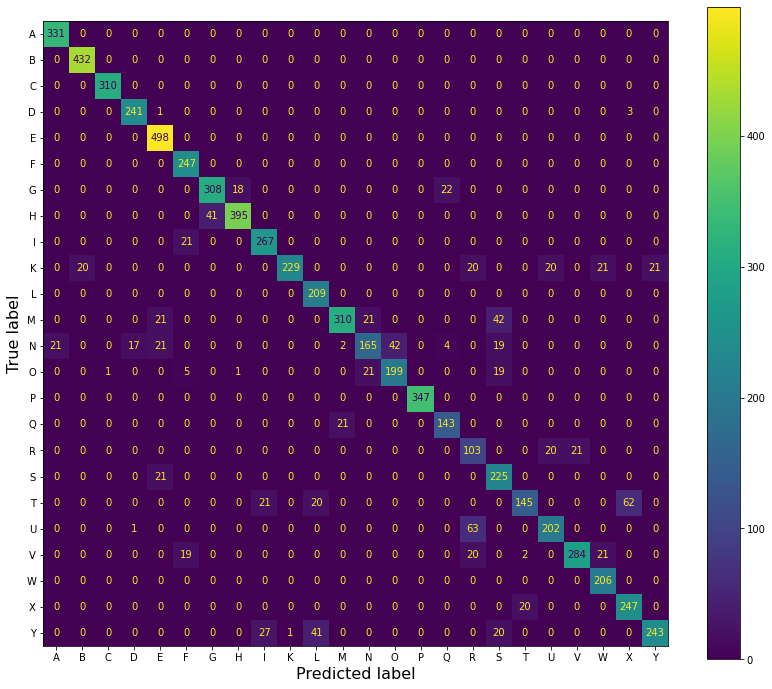

In [ ]:
test_loss, test_acc, cnn_conf_mat = get_accuracy(model_cnn1,loader=test_loader)
print("Test set: Average loss: %f, Accuracy: %.0f%%" % (test_loss,test_acc)) 
show_confusion_matrix(cnn_conf_mat)


### Results

We tried different combinations of hyperparameters (such as: number of hidden layers, learning rate, batch size). The combination which gave the highest accuracy and the lowest loss for the validation set was chosen for our model. After that, we tested the model performance with the test set, showed the results in confusion matrix and plotted training graphs.
We can see that by choosing the optimal hyperparameters for our model, we received great performance according to the loss function getting to a global minima and the high accuracy.

Displaying some of our results:

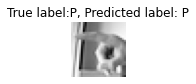

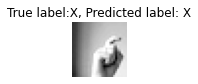

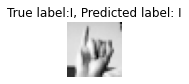

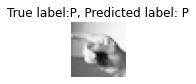

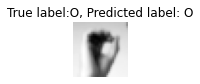

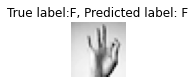

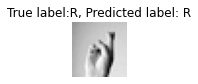

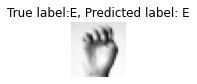

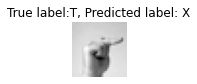

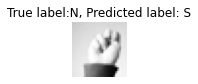

In [ ]:
num_of_samples = 50
for i in range(40,num_of_samples):
  data = x_test_norm[i]
  img = np.reshape(data, (28, 28)) 
  data = torch.Tensor(data).view(-1, 28*28)
  data = data.view(-1, 1, 28, 28)
  data = data.to(device) 
  pred = model_cnn1(data.double())
  pred = pred.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                  
  plt.figure(figsize=(2, 1))
  plt.imshow(img, cmap='Greys_r')
  plt.title(f"True label:{alphabet_dict[int(t_test[i])]}, Predicted label: {alphabet_dict[int(pred)]}")
  plt.axis('off');

Now we will introduce two networks, that were used in the article [1], and their implementations.

## LeNet5

LeNet5 is a well-known multi-layer convolution neural network architecture, introduced in 1989 in a paper by Yann LeCun and his team [2]. This network is composed of 3 convolutional layers, with the *tanh()* activation function and an average pooling layer between them. Following these layers, we have 2 fully-connected layers - the first with the *tanh()* activation function and the output layer with the *softmax()*/*log_softmax()* activation function.

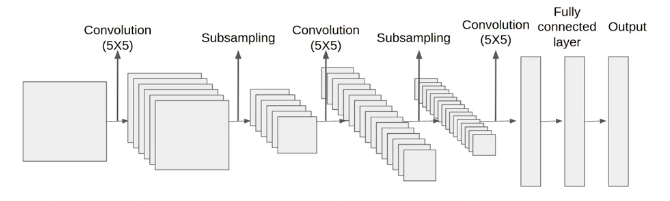

*An illustration of a LeNet5 architecture, taken from [3]*

In [ ]:
class LeNet5(nn.Module):

    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        self.tanh = nn.Tanh()
        self.avgpool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(in_features=480, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=26)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = self.tanh(x)
        x = self.avgpool1(x)
        x = self.conv2(x)
        x = self.tanh(x)
        x = self.avgpool2(x)
        x = self.conv3(x)
        x = self.tanh(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

Now, we'll train our LeNet5 model, plot the learning curve and print the test accuracy and confusion matrix:

In [ ]:
model_lenet = LeNet5()
model_lenet.to(device)

lr = 0.001

iters, losses, iters_sub, train_accs, valid_accs = train(model_lenet.double(), lr=lr, max_iters=1000,num_epochs=10)

Iter 0. [Val Acc 7.915503%] [Train Acc 8.653346%, Loss 3.237353]
Iter 50. [Val Acc 50.358140%] [Train Acc 50.130086%, Loss 1.808576]
Iter 100. [Val Acc 65.230059%] [Train Acc 65.303361%, Loss 1.270125]
Iter 134. [Val Acc 73.436931%] [Train Acc 74.071183%, Loss 1.025757]
Iter 184. [Val Acc 82.384363%] [Train Acc 83.291706%, Loss 0.758714]
Iter 234. [Val Acc 88.733762%] [Train Acc 89.208034%, Loss 0.566160]
Iter 268. [Val Acc 91.404638%] [Train Acc 91.976272%, Loss 0.465795]
Iter 318. [Val Acc 94.306179%] [Train Acc 94.723697%, Loss 0.343226]
Iter 368. [Val Acc 97.232002%] [Train Acc 97.294203%, Loss 0.250480]
Iter 402. [Val Acc 98.069686%] [Train Acc 98.079925%, Loss 0.203519]
Iter 452. [Val Acc 98.773825%] [Train Acc 98.667915%, Loss 0.151486]
Iter 502. [Val Acc 99.368702%] [Train Acc 99.594131%, Loss 0.113458]
Iter 536. [Val Acc 99.514386%] [Train Acc 99.666979%, Loss 0.094543]
Iter 586. [Val Acc 99.890737%] [Train Acc 99.901134%, Loss 0.073807]
Iter 636. [Val Acc 99.939298%] [Train A

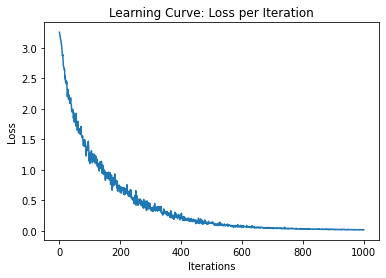

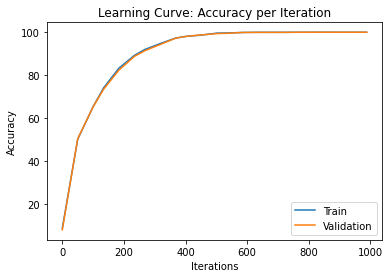

In [ ]:
plot_learning_curve(iters, losses, iters_sub, train_accs, valid_accs)

Test set: Average loss: 0.353254, Accuracy: 90%


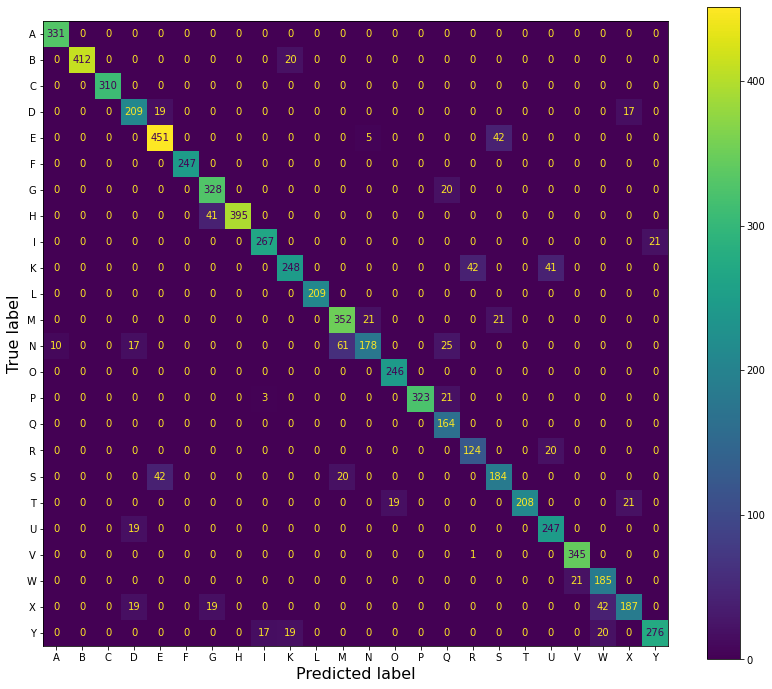

In [ ]:
test_loss, test_acc_lenet, lenet_test_conf_mat = get_accuracy(model_lenet,loader=test_loader)
print("Test set: Average loss: %f, Accuracy: %.0f%%" % (test_loss,test_acc_lenet)) 
show_confusion_matrix(lenet_test_conf_mat)

### Results

We can see that this architecture slightly improved the results over our more basic CNN. 

By comparing our results with the LeNet network from the article [1], we see that we recieved better results (ours - 90% vs theirs - 82%).

## CapsNet

Capsule network (CapsNet) is an architecture introducted in a paper from 2017 [4]. This architecture is designed to mimic the segmentation in the biological structure of neurons, and more specifically, the neurons in charge of the vision.

Every layer in the network will be divided into groups called "capsules", where each one represents a processing unit of a certain propertry of an object in the image (such as texture, hue, pose, etc.).

In their paper, Hinton and his team showed that this architecture achieved a very high performance on the MNIST database, which was comaprable to much deeper convolutional neural networks. The difference between the results of CapsNet and CNNs was especially significant when the goal was to recognize overlapping digits.

Another advantage of this architecture, is the fact that it addresses the relative spatial position of different parts of the image. For example, in the case of face recognition, most CNN architecures work by identifying key features in the image such as eyes, mouth, and nose. However, if those different parts of the image were mixed like in a Picasso painting, these models will still identify it as a face, since those features appear in the image.

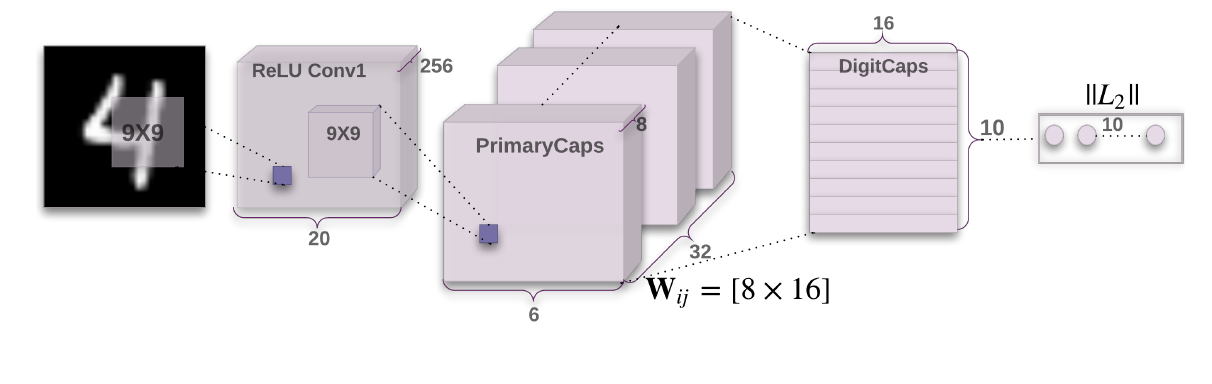
      *An illustration of a 3-layered CapsNet. Taken from the paper at [4].*



Here, we used the implementation of CapsNet by Jindong Wang and his team [5]. Several modifications were made in order to fit the model to 24 classes, and not 10 classes like MNIST, as well as changes of the hyperparameters.

In [ ]:
from torch.autograd import Variable
from tqdm import tqdm

USE_CUDA = True if torch.cuda.is_available() else False
BATCH_SIZE = 64
N_EPOCHS = 4
LEARNING_RATE = 0.01
MOMENTUM = 0.9
n_features = 10
'''
Config class to determine the parameters for capsule net
'''

class Config:
    def __init__(self):
        # CNN (cnn)
        self.cnn_in_channels = 1
        self.cnn_out_channels = 256
        self.cnn_kernel_size = 9

        # Primary Capsule (pc)
        self.pc_num_capsules = 8
        self.pc_in_channels = 256
        self.pc_out_channels = 32
        self.pc_kernel_size = 9
        self.pc_num_routes = 32 * 6 * 6

        # Digit Capsule (dc)
        self.dc_num_capsules = 26
        self.dc_num_routes = 32 * 6 * 6
        self.dc_in_channels = 8
        self.dc_out_channels = 16

        # Decoder
        self.input_width = 28
        self.input_height = 28


class ConvLayer(nn.Module):
    def __init__(self, in_channels=1, out_channels=256, kernel_size=9):
        super(ConvLayer, self).__init__()

        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=kernel_size,
                              stride=1
                              )

    def forward(self, x):
        return F.relu(self.conv(x))


class PrimaryCaps(nn.Module):
    def __init__(self, num_capsules=8, in_channels=256, out_channels=32, kernel_size=9, num_routes=32 * 6 * 6):
        super(PrimaryCaps, self).__init__()
        self.num_routes = num_routes
        self.capsules = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=2, padding=0)
            for _ in range(num_capsules)])

    def forward(self, x):
        u = [capsule(x) for capsule in self.capsules]
        u = torch.stack(u, dim=1)
        u = u.view(x.size(0), self.num_routes, -1)
        return self.squash(u)

    def squash(self, input_tensor):
        squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
        output_tensor = squared_norm * input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm))
        return output_tensor


class DigitCaps(nn.Module):
    def __init__(self, num_capsules=10, num_routes=32 * 6 * 6, in_channels=8, out_channels=16):
        super(DigitCaps, self).__init__()

        self.in_channels = in_channels
        self.num_routes = num_routes
        self.num_capsules = num_capsules

        self.W = nn.Parameter(torch.randn(1, num_routes, num_capsules, out_channels, in_channels))

    def forward(self, x):
        batch_size = x.size(0)
        x = torch.stack([x] * self.num_capsules, dim=2).unsqueeze(4)

        W = torch.cat([self.W] * batch_size, dim=0)
        u_hat = torch.matmul(W, x)

        b_ij = Variable(torch.zeros(1, self.num_routes, self.num_capsules, 1))
        if USE_CUDA:
            b_ij = b_ij.cuda()

        num_iterations = 3
        for iteration in range(num_iterations):
            c_ij = F.softmax(b_ij, dim=1)
            c_ij = torch.cat([c_ij] * batch_size, dim=0).unsqueeze(4)

            s_j = (c_ij * u_hat).sum(dim=1, keepdim=True)
            v_j = self.squash(s_j)

            if iteration < num_iterations - 1:
                a_ij = torch.matmul(u_hat.transpose(3, 4), torch.cat([v_j] * self.num_routes, dim=1))
                b_ij = b_ij + a_ij.squeeze(4).mean(dim=0, keepdim=True)

        return v_j.squeeze(1)

    def squash(self, input_tensor):
        squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
        output_tensor = squared_norm * input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm))
        return output_tensor


class Decoder(nn.Module):
    def __init__(self, input_width=28, input_height=28, input_channel=1):
        super(Decoder, self).__init__()
        self.input_width = input_width
        self.input_height = input_height
        self.input_channel = input_channel
        self.reconstraction_layers = nn.Sequential(
            nn.Linear(16 * 26, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, self.input_height * self.input_width * self.input_channel),
            nn.Sigmoid()
        )

    def forward(self, x, data):
        classes = torch.sqrt((x ** 2).sum(2))
        classes = F.softmax(classes, dim=0)

        _, max_length_indices = classes.max(dim=1)
        masked = Variable(torch.sparse.torch.eye(26))
        if USE_CUDA:
            masked = masked.cuda()
        masked = masked.index_select(dim=0, index=Variable(max_length_indices.squeeze(1).data))
        t = (x * masked[:, :, None, None]).view(x.size(0), -1)
        reconstructions = self.reconstraction_layers(t)
        reconstructions = reconstructions.view(-1, self.input_channel, self.input_width, self.input_height)
        return reconstructions, masked


class CapsNet(nn.Module):
    def __init__(self, config=None):
        super(CapsNet, self).__init__()
        if config:
            self.conv_layer = ConvLayer(config.cnn_in_channels, config.cnn_out_channels, config.cnn_kernel_size)
            self.primary_capsules = PrimaryCaps(config.pc_num_capsules, config.pc_in_channels, config.pc_out_channels,
                                                config.pc_kernel_size, config.pc_num_routes)
            self.digit_capsules = DigitCaps(config.dc_num_capsules, config.dc_num_routes, config.dc_in_channels,
                                            config.dc_out_channels)
            self.decoder = Decoder(config.input_width, config.input_height, config.cnn_in_channels)
        else:
            self.conv_layer = ConvLayer()
            self.primary_capsules = PrimaryCaps()
            self.digit_capsules = DigitCaps()
            self.decoder = Decoder()

        self.mse_loss = nn.MSELoss()

    def forward(self, data):
        output = self.digit_capsules(self.primary_capsules(self.conv_layer(data)))
        reconstructions, masked = self.decoder(output, data)
        return output, reconstructions, masked

    def loss(self, data, x, target, reconstructions):
        return self.margin_loss(x, target) + self.reconstruction_loss(data, reconstructions)

    def margin_loss(self, x, labels, size_average=True):
        batch_size = x.size(0)

        v_c = torch.sqrt((x ** 2).sum(dim=2, keepdim=True))

        left = F.relu(0.9 - v_c).view(batch_size, -1)
        right = F.relu(v_c - 0.1).view(batch_size, -1)

        loss = labels * left + 0.5 * (1.0 - labels) * right
        loss = loss.sum(dim=1).mean()

        return loss

    def reconstruction_loss(self, data, reconstructions):
        loss = self.mse_loss(reconstructions.view(reconstructions.size(0), -1), data.view(reconstructions.size(0), -1))
        return loss * 0.0005

def train_capsnet(model, optimizer, train_loader, num_epochs):
    capsule_net = model
    capsule_net.train()
    n_batch = len(list(enumerate(train_loader)))
    total_loss = 0
    n = 0 # the number of iterations
    train_accs, valid_accs, iters, iters_sub, losses = [], [], [], [], []
    for epoch in range(1,num_epochs):
      for batch_id, ar in enumerate(train_loader):
          data = ar[:,1:].type(torch.double)
          target = ar[:,0].type(torch.int64)
          target = torch.sparse.torch.eye(26).index_select(dim=0, index=target)
          data, target = Variable(data), Variable(target)

          data = data.view(-1, 28*28)
          data = data.view(-1, 1, 28, 28)

          if USE_CUDA:
              data, target = data.cuda(), target.cuda()

          optimizer.zero_grad()
          output, reconstructions, masked = capsule_net(data)
          loss = capsule_net.loss(data, output, target, reconstructions)
          loss.backward()
          optimizer.step()
          correct = sum(np.argmax(masked.data.cpu().numpy(), 1) == np.argmax(target.data.cpu().numpy(), 1))
          train_loss = loss.item()
          total_loss += train_loss
          iters.append(n)
          losses.append(loss.item())
          if batch_id % 100 == 0:
              current_acc, current_loss, _ = get_accuracy_capsnet(capsule_net, train_loader)
              valid_acc, valid_loss, _ = get_accuracy_capsnet(capsule_net, val_loader)
              iters_sub.append(n)
              train_accs.append(current_acc)
              valid_accs.append(valid_acc)
              tqdm.write("Epoch: [{}/{}], Batch: [{}/{}], train accuracy: {:.6f}%, validation accuracy: {:.6f}%, train loss: {:.6f}".format(
                  epoch,
                  num_epochs,
                  batch_id + 1,
                  n_batch,
                  current_acc,
                  valid_acc,
                  current_loss
                  ))
          n += 1
      tqdm.write('Epoch: [{}/{}], train loss: {:.6f}'.format(epoch,num_epochs,total_loss / len(train_loader.dataset)))
    return train_accs, valid_accs, iters, iters_sub, losses

def get_accuracy_capsnet(capsule_net, loader):
    capsule_net.eval()
    final_loss = 0
    correct = 0

    pred_list = []
    true_list = []
    for batch_id, ar in enumerate(loader):
        data = ar[:,1:].type(torch.double)
        target = ar[:,0].type(torch.int64)
        target = torch.sparse.torch.eye(26).index_select(dim=0, index=target)
        data, target = Variable(data), Variable(target)

        data = data.view(-1, 28*28)
        data = data.view(-1, 1, 28, 28)

        if USE_CUDA:
            data, target = data.cuda(), target.cuda()

        output, reconstructions, masked = capsule_net(data)
        loss = capsule_net.loss(data, output, target, reconstructions)

        final_loss += loss.item()
        correct += sum(np.argmax(masked.data.cpu().numpy(), 1) ==
                       np.argmax(target.data.cpu().numpy(), 1))
        
        for y in np.argmax(masked.data.cpu().numpy(), 1):
          pred_list.append(y)

        for y in np.argmax(target.data.cpu().numpy(), 1):  
          true_list.append(y)

    conf_mat = confusion_matrix(true_list, pred_list, labels=list(range(0,9))+list(range(10,25)))  
    acc = correct * 100 / len(loader.dataset)
    final_loss /= len(loader.dataset)
    return acc, final_loss, conf_mat

Again, we'll train the model and print its performance:

In [ ]:
gc.collect()

torch.manual_seed(1)
config = Config()

capsule_net = CapsNet(config)
capsule_net = torch.nn.DataParallel(capsule_net)
if USE_CUDA:
    capsule_net = capsule_net.cuda()
capsule_net = capsule_net.module.double()
torch.cuda.empty_cache()
optimizer = torch.optim.Adam(capsule_net.parameters())
train_accs, valid_accs, iters, iters_sub, train_losses = train_capsnet(capsule_net, optimizer, train_loader, N_EPOCHS)

torch.save(capsule_net.state_dict(),  "/content/gdrive/My Drive/Intro_to_Deep_Learning/Project/capsnet.pt")

Epoch: [1/4], Batch: [1/301], train accuracy: 19.564991%, validation accuracy: 18.720408%, train loss: 0.013812
Epoch: [1/4], Batch: [101/301], train accuracy: 88.172547%, validation accuracy: 86.888430%, train loss: 0.010305
Epoch: [1/4], Batch: [201/301], train accuracy: 98.126756%, validation accuracy: 97.693335%, train loss: 0.007720
Epoch: [1/4], Batch: [301/301], train accuracy: 98.855240%, validation accuracy: 98.785966%, train loss: 0.007729
Epoch: [1/4], train loss: 0.009822
Epoch: [2/4], Batch: [1/301], train accuracy: 98.876054%, validation accuracy: 98.810246%, train loss: 0.007699
Epoch: [2/4], Batch: [101/301], train accuracy: 99.854303%, validation accuracy: 99.866456%, train loss: 0.005063
Epoch: [2/4], Batch: [201/301], train accuracy: 99.901134%, validation accuracy: 99.866456%, train loss: 0.004453
Epoch: [2/4], Batch: [301/301], train accuracy: 99.968779%, validation accuracy: 99.963579%, train loss: 0.002467
Epoch: [2/4], train loss: 0.015167
Epoch: [3/4], Batch: [

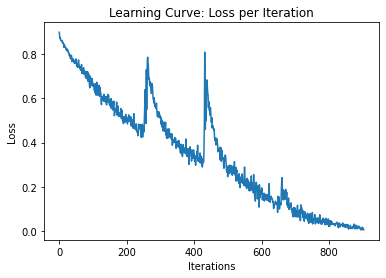

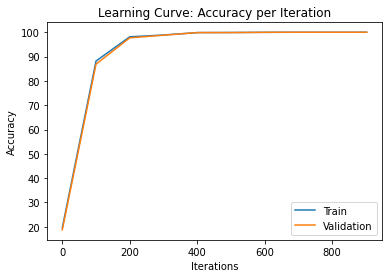

In [ ]:
plot_learning_curve(iters, train_losses, iters_sub, train_accs, valid_accs)

We can notice that the CapsNet's training curve does not look like the typical learning curve (decreases approximately monotonically). This form is caused due to the use of capsules during network training.

Training the CapsNet model takes signifacntly more time than training the previous CNNs. Therefore, it's important to save the model's state dictionary so we can load it later.

In [ ]:
from datetime import datetime

now = datetime.now() 
dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")

torch.save(capsule_net.state_dict(),  "/content/gdrive/My Drive/Intro_to_Deep_Learning/Project/capsnet_" + dt_string + ".pt")

test accuracy: 94.185722%, loss: 0.000046


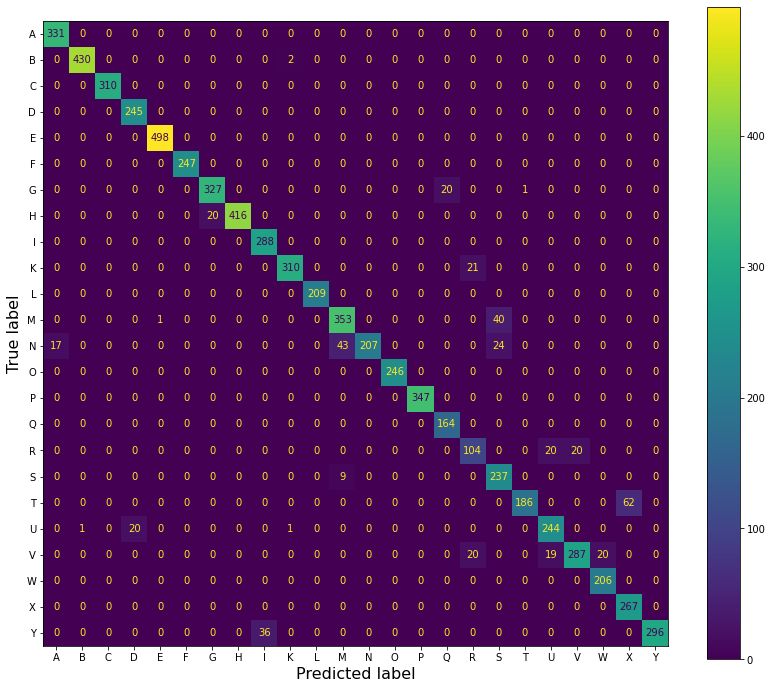

In [ ]:
gc.collect()
torch.cuda.empty_cache()

torch.manual_seed(1)
config = Config()

capsule_net = CapsNet(config)
capsule_net = torch.nn.DataParallel(capsule_net)
if USE_CUDA:
    capsule_net = capsule_net.cuda()
capsule_net = capsule_net.module.double()
capsule_net.load_state_dict(torch.load('/content/gdrive/My Drive/Intro_to_Deep_Learning/Project/capsnet_12_01_2022_12_55_38.pt'))
torch.cuda.empty_cache()
test_acc_capsnet, test_loss, capsnet_test_conf_mat = get_accuracy_capsnet(capsule_net, test_loader)
tqdm.write(
    "test accuracy: {:.6f}%, loss: {:.6f}".format(test_acc_capsnet, test_loss / len(test_loader)))
show_confusion_matrix(capsnet_test_conf_mat)

### Results

By comparing our results with the CapsNet network from the article [1], we see that we recieved better results (ours - 95% vs theirs - 89%).

We can see that the performance of this model is significantly higher that the previous ones. On the other hand, it is more complicated and training it took a longer time.

## Results Analysis

In order to analyze our results further, we'll define a function which will show us recurring results between the 3 confusion matrices we have.

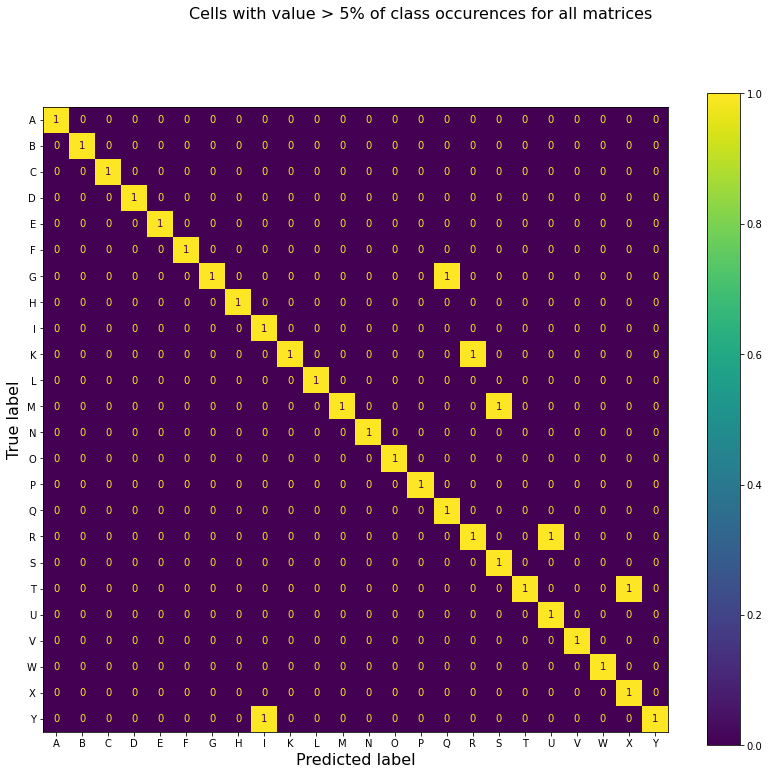

In [ ]:
def mismatch_per(conf_mat, x, y):
  num_of_occurences = np.sum(conf_mat[x,:])
  return conf_mat[x,y] * 100 / num_of_occurences

def show_cells_with_high__values(conf_mat1, conf_mat2, conf_mat3, th = 5):
  confusing_pairs = []
  mat = np.zeros(conf_mat1.shape)
  display_labels=[alphabet_dict[i] for i in list(range(0,9))+list(range(10,25))]
  for x in range(0, conf_mat1.shape[0]):
    for y in range(0, conf_mat1.shape[1]):     
      if (mismatch_per(conf_mat1,x,y) >= th) and (mismatch_per(conf_mat2,x,y) >= th) and (mismatch_per(conf_mat3,x,y) >= th):
        mat[x,y] = 1
        if x != y:
          confusing_pairs.append([display_labels[x], display_labels[y]])

  disp = ConfusionMatrixDisplay(mat, display_labels=display_labels)
  fig, ax = plt.subplots(figsize=(14, 12))
  ax.set_xlabel('Preicted Label', fontsize=16)
  ax.set_ylabel('True Label', fontsize=16) 
  fig.suptitle(f"Cells with value > {th}% of class occurences for all matrices", fontsize=16)
  disp.plot(ax=ax)

  return confusing_pairs

confusing_pairs = show_cells_with_high__values(cnn_conf_mat, lenet_test_conf_mat, capsnet_test_conf_mat)

In the above matrix, if a cell has a value of 1, it means that in all 3 confusion matrices the corresponding cell has a value of 5% or more of the total number of occurences for the class. This could indicate that a specific class is likely to be confused with another. Next, we'll display images of letter gestures for cells with a value of 1 which are not on the main diagonal. These are letter pairs for which the models had a relatively low performance. It is worth noting that the matrices are not symetric, meaning that if a certain model frequently classified a letter of label $L_1$ as label $L_2$, it does not mean that it frequently classified  a letter of label $L_2$ as label $L_1$.

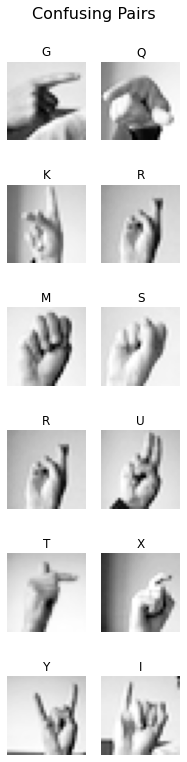

In [ ]:
import matplotlib.gridspec as gridspec

def get_confusing_pair(letters):
  imgs = []
  for i in [0,1]:
    idx = 0
    letter = letters[i]
    letter_not_found = True
    while letter_not_found:
      if (alphabet_dict[int(t_test[idx])] == letter):
        letter_not_found = False
        imgs.append(x_test_norm[idx])
      idx += 1
  return imgs    

fig, axs = plt.subplots(len(confusing_pairs), 2, figsize=(2*len(confusing_pairs), 2*len(confusing_pairs)))
fig.suptitle('Confusing Pairs', fontsize=16)

for pair_idx in range(0,len(confusing_pairs)):
  pair = confusing_pairs[pair_idx]
  pair_imgs = get_confusing_pair(pair)

  img1 = np.reshape(pair_imgs[0], (28, 28))
  img2 = np.reshape(pair_imgs[1], (28, 28))

  axs[pair_idx,0].imshow(img1, cmap='Greys_r')
  axs[pair_idx,0].axis('off')
  axs[pair_idx,0].set_title(pair[0])
  axs[pair_idx,1].imshow(img2, cmap='Greys_r')
  axs[pair_idx,1].set_title(pair[1])
  axs[pair_idx,1].axis('off')

plt.subplots_adjust(bottom=0.1, left=0.4, right=0.6, top = 0.93)
plt.show()

By looking at the images, it is easy to see why most of these pairs confused the models.

Now, we will compare the number of parameters in each network.

In [ ]:
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In [ ]:
print('Number of parameters in our CNN: {}'.format(get_n_params(model_cnn1)))
print('Number of parameters in LeNet: {}'.format(get_n_params(model_lenet)))
print('Number of parameters in CapsNet: {}'.format(get_n_params(capsule_net)))

Number of parameters in our CNN: 78656
Number of parameters in LeNet: 62586
Number of parameters in CapsNet: 10705936


We can see that the LeNet uses the lowest number of trainable parameters.

As expected, the CapsNet, which its training step took the longest (around two hours), has the highest number of trainable parameters (~170 times higher than the LeNet's).

For last, we will display a bar graph showing the test accuracies of the three networks.

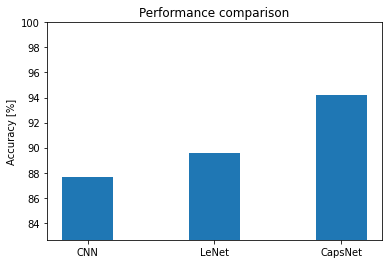

In [ ]:
accuracy_list = [test_acc,test_acc_lenet,test_acc_capsnet]

plt.bar(('CNN', 'LeNet', 'CapsNet'), accuracy_list, width=0.4)
plt.ylim((min(accuracy_list)-5, 100))
plt.ylabel('Accuracy [%]')
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(10)
plt.title('Performance comparison');

## Conclusion

In summary, we wanted to implement a neural network which identifes the letters from sign languate images.

First, after checking the optimal hyperparameters, we implemented a convolutional neural network.
After that, we used Metin Bilgin and Korhan Mutludo˘gan paper in order to implement two neural networks.
The first one was the Lenet which slightly improved the accuracy.
The second one was the CapsNet which miraculously improved our network.

We can see that we recieved the best performance with the CapsNet.

By looking at the networks' accuracies and their number of parameters, it can be concluded that in order to get higher accuracy than ~90%, we will need enormous amount of trainable parameters. 
The trade-off would be the risk of overfitting and much longer training procedure and higher computation complexity. 

## References

[1] M. Bilgin and K. Mutludoğan, "American Sign Language Character Recognition with Capsule Networks," 2019 3rd International Symposium on Multidisciplinary Studies and Innovative Technologies (ISMSIT), 2019, pp. 1-6, doi: 10.1109/ISMSIT.2019.8932829.

[2] Y. LeCun, L. Bottou, Y. Bengio, P. Haffner et al., “Gradient-based
learning applied to document recognition,” Proceedings of the IEEE,
vol. 86, no. 11, pp. 2278–2324, 1998.

[3] https://www.analyticsvidhya.com/blog/2021/03/the-architecture-of-lenet-5/

[4] S. Sabour, N. Frosst, and G. E. Hinton, “Dynamic routing between
capsules,” in Advances in neural information processing systems, 2017,
pp. 3856–3866.

[5] https://github.com/jindongwang/Pytorch-CapsuleNet